# MLP
Convert CNN_264 to an MLP.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-27 14:48:14.374786


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

2023-03-27 14:48:14.457980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/


2023-03-27 14:48:23.993021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.10.0
sklearn 1.1.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(8, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 14:48:27.566895
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16512     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,041
Trainable params: 17,041
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 14:48:27.828752
Load RCI from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 14:48:42.635953

Training # 1 1
2023-03-27 14:48:42.636001
2023-03-27 14:48:42.636027
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 14:48:42.712056


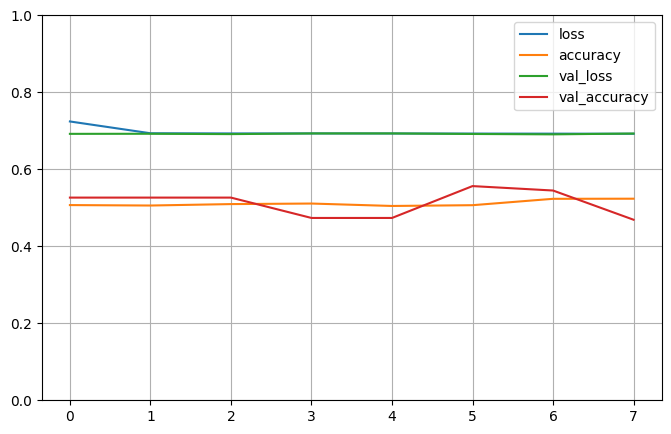


2023-03-27 14:48:46.830943

Testing # 1 1
2023-03-27 14:48:46.830983
2023-03-27 14:48:46.831001
PREDICT
2023-03-27 14:48:46.835801
Test 1:0 458:412 52.64%
Predict 1:0 60:810  6.90%
Test sizes (870, 257) (870,)
Range of scores: 0.46510658 to 0.50226355
Score threshold 0.5
Confusion matrix
 [[380  32]
 [430  28]]
Normalized matrix
 [[0.43678161 0.03678161]
 [0.49425287 0.03218391]]


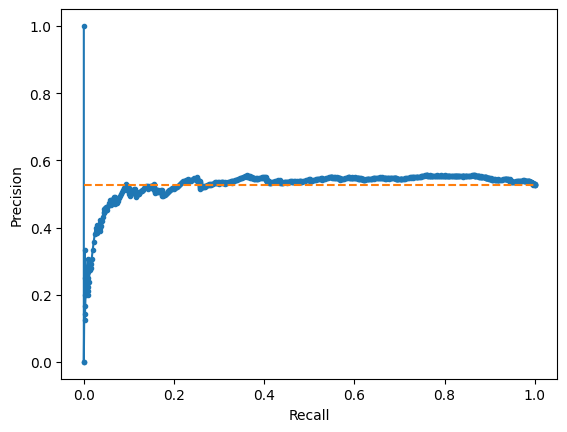

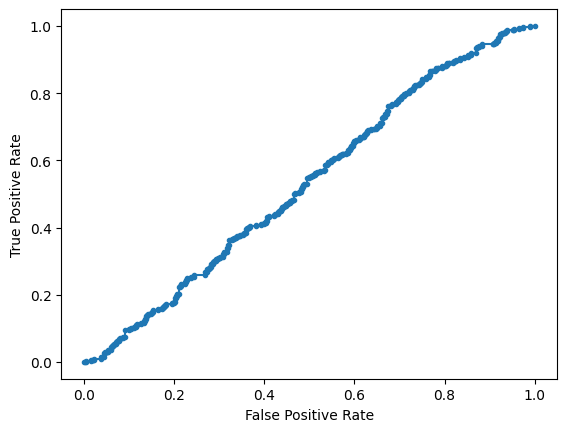

Accuracy: 46.90% Precision: 46.67% Recall: 6.11%
F1: 10.81% MCC: -0.0326
AUPRC: 52.76% AUROC: 53.18%
 accuracy [46.89655172413793]
 precision [46.666666666666664]
 recall [6.11353711790393]
 F1 [10.81081081081081]
 MCC [-0.03258030250460679]
 AUPRC [52.75995775232969]
 AUROC [53.18024759401365]
2023-03-27 14:48:47.375979

Training # 1 2
2023-03-27 14:48:47.376033
2023-03-27 14:48:47.376055
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 14:48:47.440178


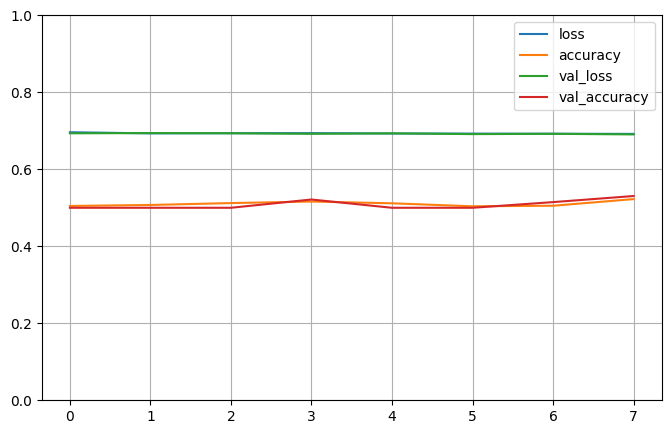


2023-03-27 14:48:50.939761

Testing # 1 2
2023-03-27 14:48:50.939818
2023-03-27 14:48:50.939833
PREDICT
2023-03-27 14:48:50.944643
Test 1:0 442:442 50.00%
Predict 1:0 379:505 42.87%
Test sizes (884, 257) (884,)
Range of scores: 0.4526317 to 0.5078647
Score threshold 0.5
Confusion matrix
 [[266 176]
 [239 203]]
Normalized matrix
 [[0.30090498 0.19909502]
 [0.27036199 0.22963801]]


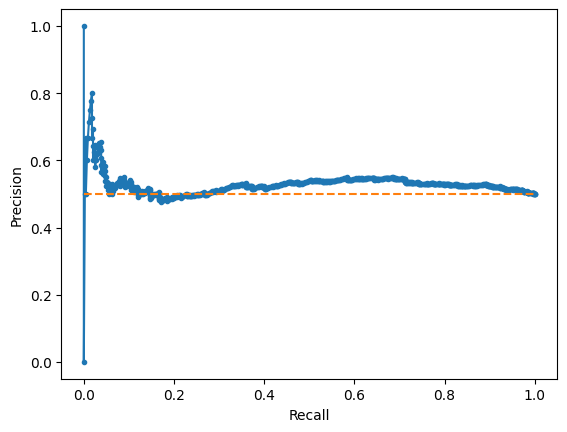

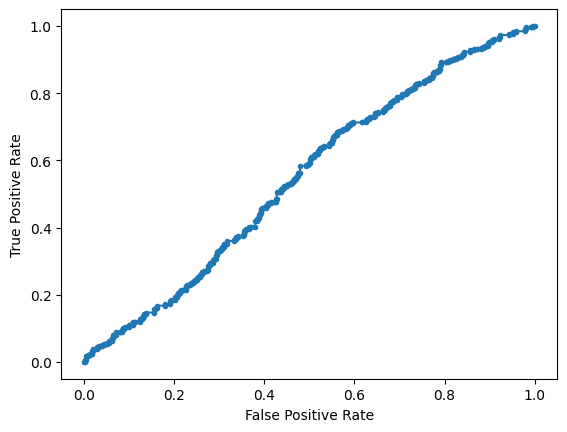

Accuracy: 53.05% Precision: 53.56% Recall: 45.93%
F1: 49.45% MCC: 0.0617
AUPRC: 52.77% AUROC: 55.00%
 accuracy [53.05429864253394]
 precision [53.562005277044854]
 recall [45.92760180995475]
 F1 [49.451887941534714]
 MCC [0.0617160994385529]
 AUPRC [52.77453910314358]
 AUROC [55.003224749698]
2023-03-27 14:48:51.422608

Training # 1 3
2023-03-27 14:48:51.422682
2023-03-27 14:48:51.422719
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 14:48:51.479684


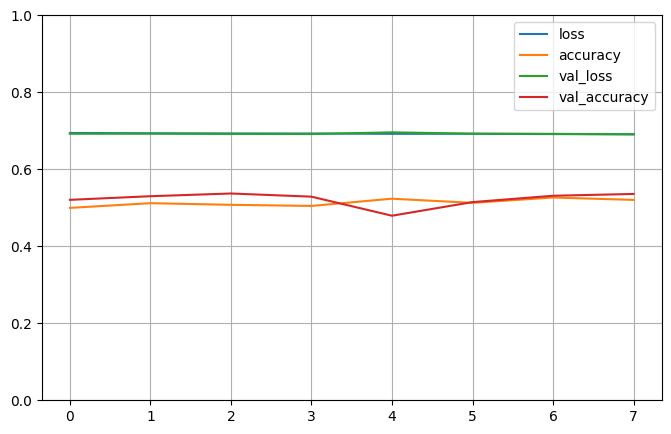


2023-03-27 14:48:54.907005

Testing # 1 3
2023-03-27 14:48:54.907052
2023-03-27 14:48:54.907070
PREDICT
2023-03-27 14:48:54.911605
Test 1:0 442:407 52.06%
Predict 1:0 768:81 90.46%
Test sizes (849, 257) (849,)
Range of scores: 0.46897793 to 0.54655904
Score threshold 0.5
Confusion matrix
 [[ 47 360]
 [ 34 408]]
Normalized matrix
 [[0.05535925 0.42402827]
 [0.04004711 0.48056537]]


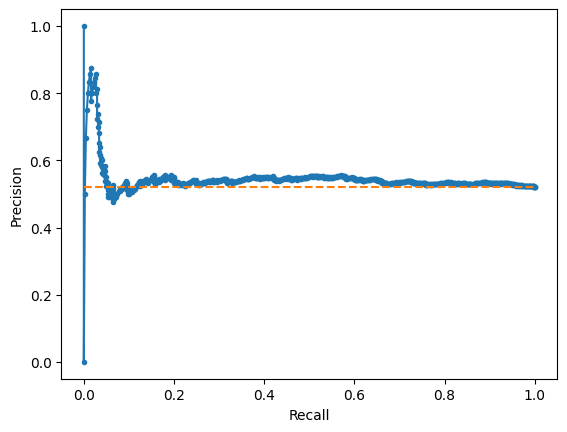

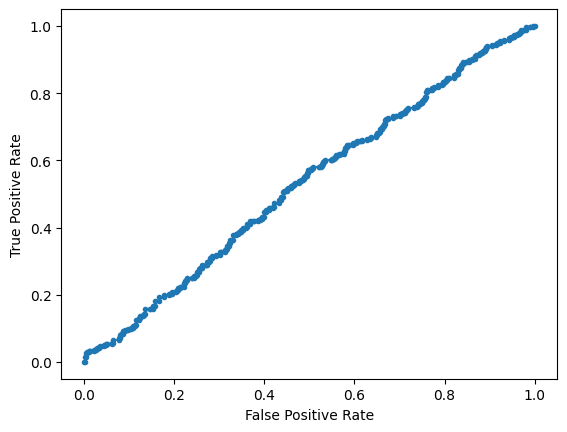

Accuracy: 53.59% Precision: 53.12% Recall: 92.31%
F1: 67.44% MCC: 0.0656
AUPRC: 54.42% AUROC: 53.06%
 accuracy [53.592461719670204]
 precision [53.125]
 recall [92.3076923076923]
 F1 [67.43801652892563]
 MCC [0.06556583942022934]
 AUPRC [54.42279268883085]
 AUROC [53.05735599853247]
2023-03-27 14:48:55.400064

Training # 1 4
2023-03-27 14:48:55.400115
2023-03-27 14:48:55.400138
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 14:48:55.459824


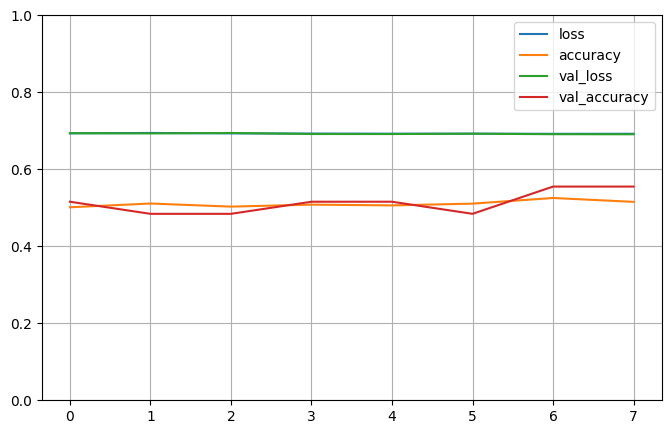


2023-03-27 14:48:58.881581

Testing # 1 4
2023-03-27 14:48:58.881643
2023-03-27 14:48:58.881669
PREDICT
2023-03-27 14:48:58.886740
Test 1:0 459:431 51.57%
Predict 1:0 555:335 62.36%
Test sizes (890, 257) (890,)
Range of scores: 0.468561 to 0.5134354
Score threshold 0.5
Confusion matrix
 [[185 246]
 [150 309]]
Normalized matrix
 [[0.20786517 0.27640449]
 [0.16853933 0.34719101]]


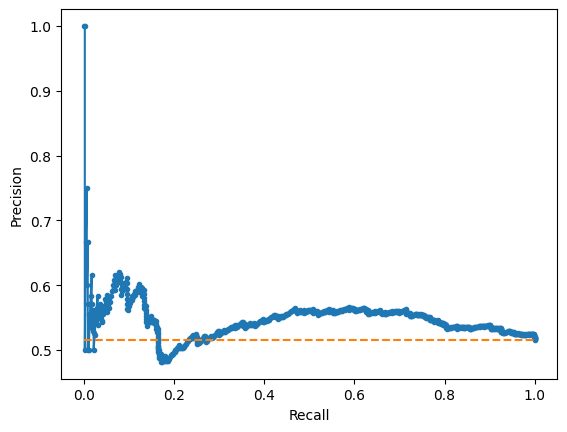

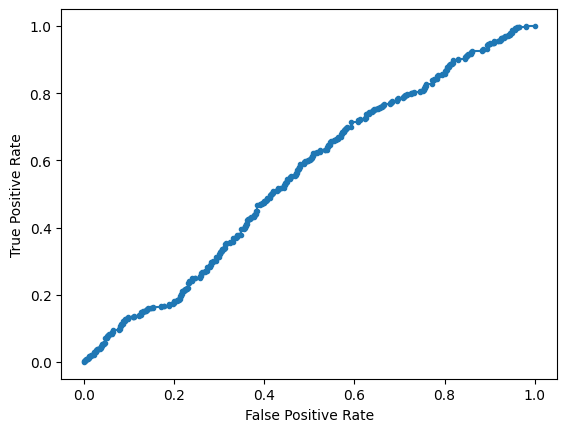

Accuracy: 55.51% Precision: 55.68% Recall: 67.32%
F1: 60.95% MCC: 0.1057
AUPRC: 54.69% AUROC: 55.19%
 accuracy [55.50561797752809]
 precision [55.67567567567567]
 recall [67.3202614379085]
 F1 [60.94674556213019]
 MCC [0.10566538387768343]
 AUPRC [54.6898851710745]
 AUROC [55.187055487314794]
2023-03-27 14:48:59.401121

Training # 1 5
2023-03-27 14:48:59.401185
2023-03-27 14:48:59.401212
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 14:48:59.458073


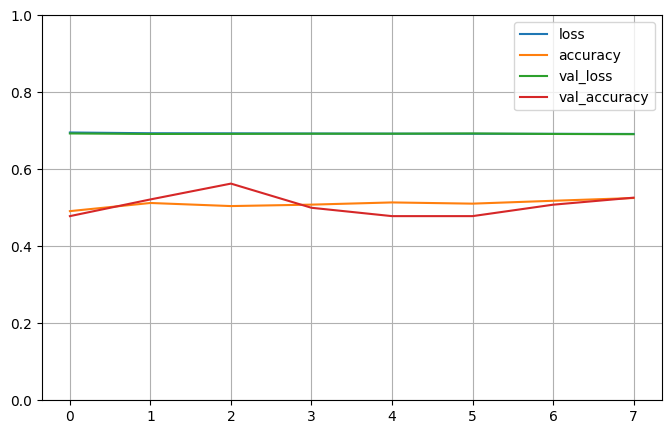


2023-03-27 14:49:03.213159

Testing # 1 5
2023-03-27 14:49:03.213207
2023-03-27 14:49:03.213222
PREDICT
2023-03-27 14:49:03.218186
Test 1:0 457:419 52.17%
Predict 1:0 490:386 55.94%
Test sizes (876, 257) (876,)
Range of scores: 0.46214077 to 0.51127386
Score threshold 0.5
Confusion matrix
 [[195 224]
 [191 266]]
Normalized matrix
 [[0.22260274 0.25570776]
 [0.21803653 0.30365297]]


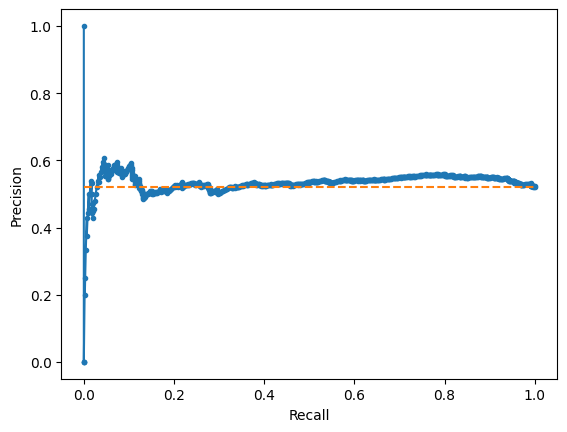

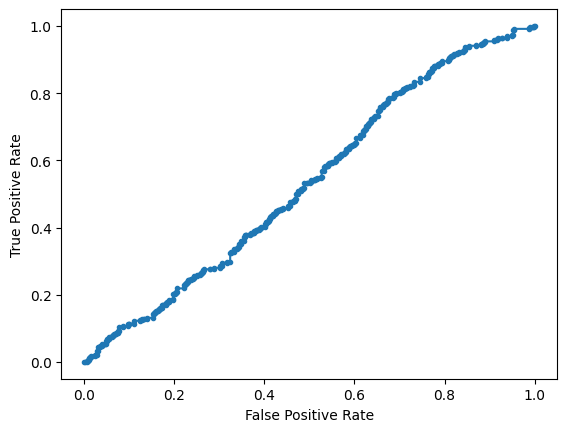

Accuracy: 52.63% Precision: 54.29% Recall: 58.21%
F1: 56.18% MCC: 0.0477
AUPRC: 53.44% AUROC: 53.54%
 accuracy [52.62557077625571]
 precision [54.285714285714285]
 recall [58.20568927789934]
 F1 [56.177402323125655]
 MCC [0.047743684175786436]
 AUPRC [53.44330982085778]
 AUROC [53.535561903667684]
2023-03-27 14:49:03.726226

Training # 2 1
2023-03-27 14:49:03.726291
2023-03-27 14:49:03.726332
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 14:49:03.783664


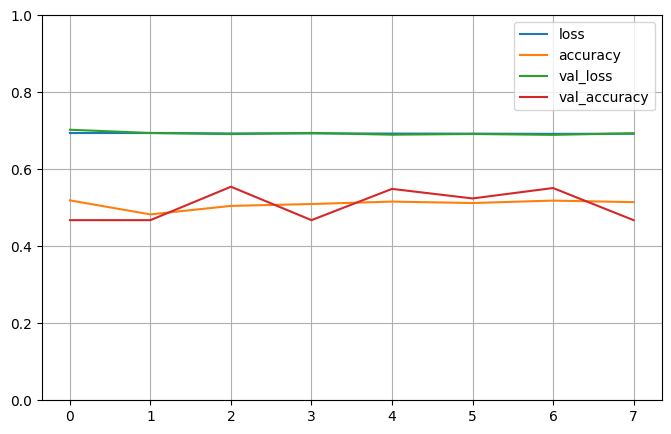


2023-03-27 14:49:07.686770

Testing # 2 1
2023-03-27 14:49:07.686818
2023-03-27 14:49:07.686834
PREDICT
2023-03-27 14:49:07.692031
Test 1:0 472:415 53.21%
Predict 1:0 0:887  0.00%
Test sizes (887, 257) (887,)
Range of scores: 0.4448012 to 0.49801755
Score threshold 0.5
Confusion matrix
 [[415   0]
 [472   0]]
Normalized matrix
 [[0.46786922 0.        ]
 [0.53213078 0.        ]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


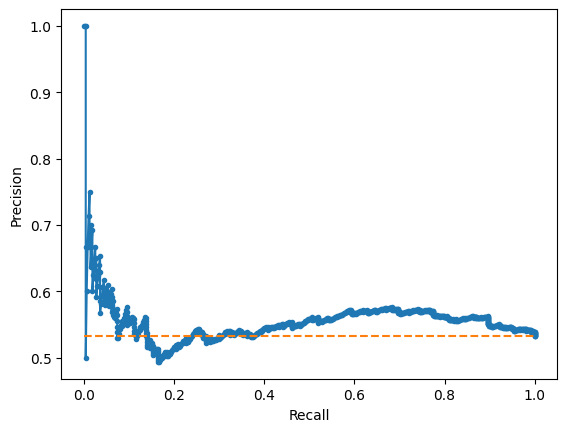

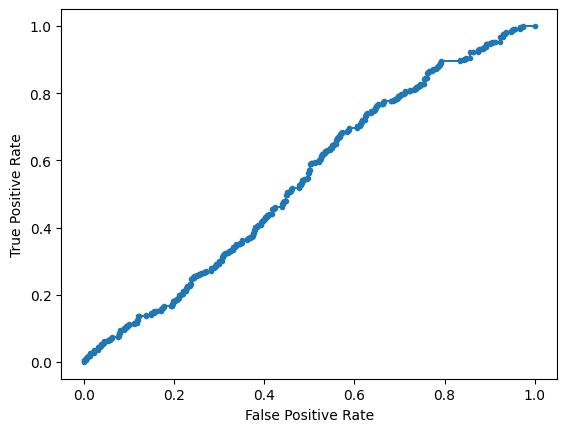

Accuracy: 46.79% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 55.56% AUROC: 54.24%
 accuracy [46.786922209695604]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [55.55791511608349]
 AUROC [54.244945885235865]
2023-03-27 14:49:08.215453

Training # 2 2
2023-03-27 14:49:08.215530
2023-03-27 14:49:08.215559
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 14:49:08.270634


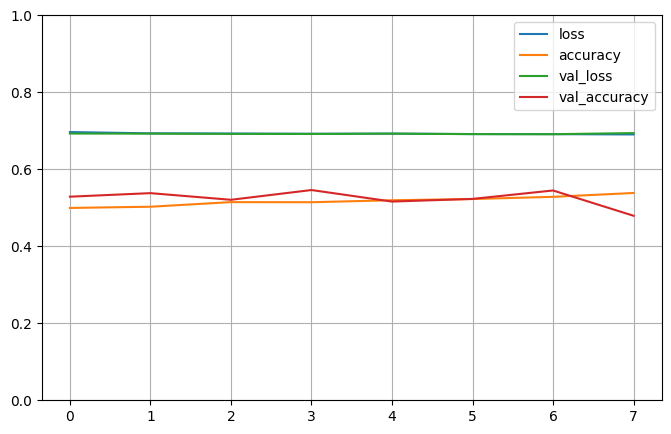


2023-03-27 14:49:12.850821

Testing # 2 2
2023-03-27 14:49:12.850859
2023-03-27 14:49:12.850874
PREDICT
2023-03-27 14:49:12.855644
Test 1:0 452:416 52.07%
Predict 1:0 0:868  0.00%
Test sizes (868, 257) (868,)
Range of scores: 0.430772 to 0.4989375
Score threshold 0.5
Confusion matrix
 [[416   0]
 [452   0]]
Normalized matrix
 [[0.47926267 0.        ]
 [0.52073733 0.        ]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


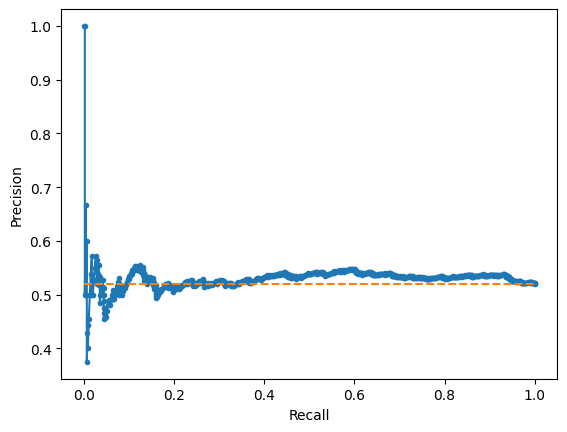

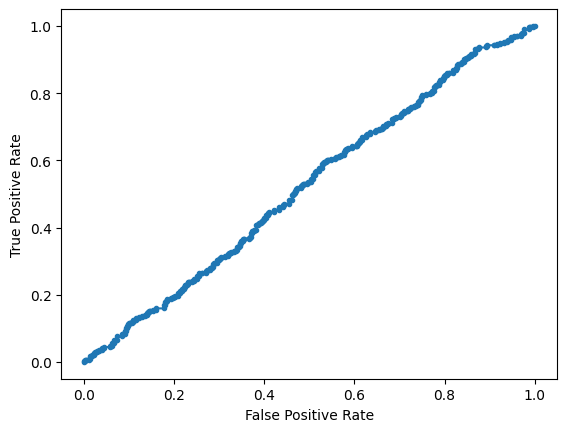

Accuracy: 47.93% Precision: 0.00% Recall: 0.00%
F1: 0.00% MCC: 0.0000
AUPRC: 53.01% AUROC: 52.29%
 accuracy [47.926267281105986]
 precision [0.0]
 recall [0.0]
 F1 [0.0]
 MCC [0.0]
 AUPRC [53.0130211936058]
 AUROC [52.288174353301564]
2023-03-27 14:49:13.361989

Training # 2 3
2023-03-27 14:49:13.362041
2023-03-27 14:49:13.362064
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 14:49:13.431731


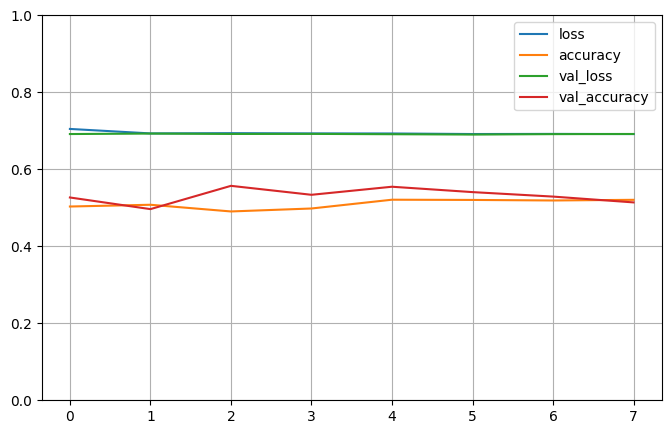


2023-03-27 14:49:17.335024

Testing # 2 3
2023-03-27 14:49:17.335064
2023-03-27 14:49:17.335080
PREDICT
2023-03-27 14:49:17.340420
Test 1:0 453:407 52.67%
Predict 1:0 431:429 50.12%
Test sizes (860, 257) (860,)
Range of scores: 0.4505383 to 0.51469123
Score threshold 0.5
Confusion matrix
 [[209 198]
 [220 233]]
Normalized matrix
 [[0.24302326 0.23023256]
 [0.25581395 0.27093023]]


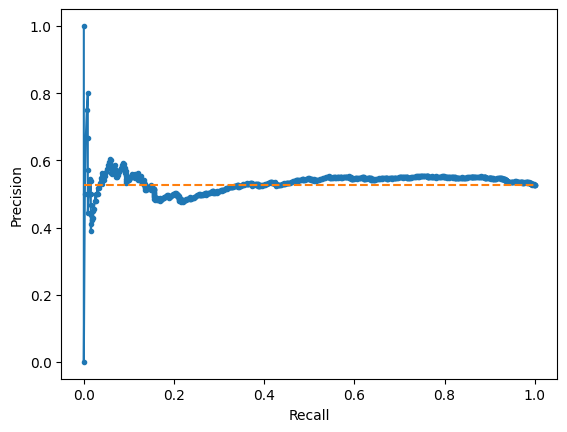

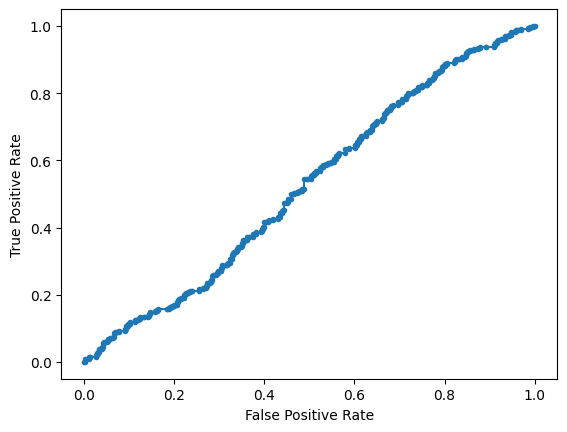

Accuracy: 51.40% Precision: 54.06% Recall: 51.43%
F1: 52.71% MCC: 0.0278
AUPRC: 53.45% AUROC: 52.50%
 accuracy [51.3953488372093]
 precision [54.060324825986086]
 recall [51.434878587196465]
 F1 [52.71493212669682]
 MCC [0.027822488971309667]
 AUPRC [53.451672080327505]
 AUROC [52.50066442119422]
2023-03-27 14:49:17.936029

Training # 2 4
2023-03-27 14:49:17.936089
2023-03-27 14:49:17.936116
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 14:49:17.999887


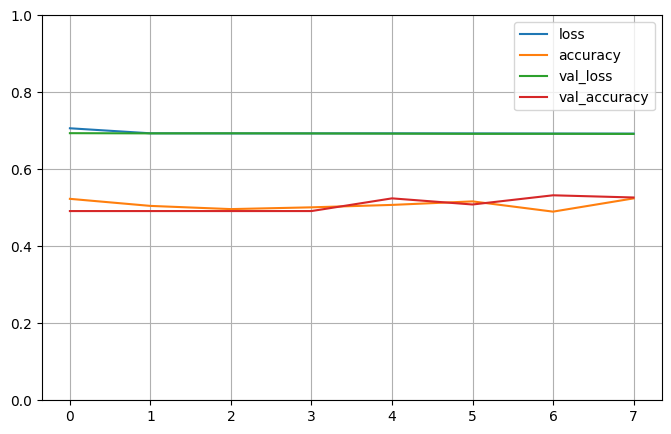


2023-03-27 14:49:21.943323

Testing # 2 4
2023-03-27 14:49:21.943368
2023-03-27 14:49:21.943387
PREDICT
2023-03-27 14:49:21.949947
Test 1:0 432:447 49.15%
Predict 1:0 472:407 53.70%
Test sizes (879, 257) (879,)
Range of scores: 0.4812998 to 0.5057765
Score threshold 0.5
Confusion matrix
 [[219 228]
 [188 244]]
Normalized matrix
 [[0.24914676 0.25938567]
 [0.21387941 0.27758817]]


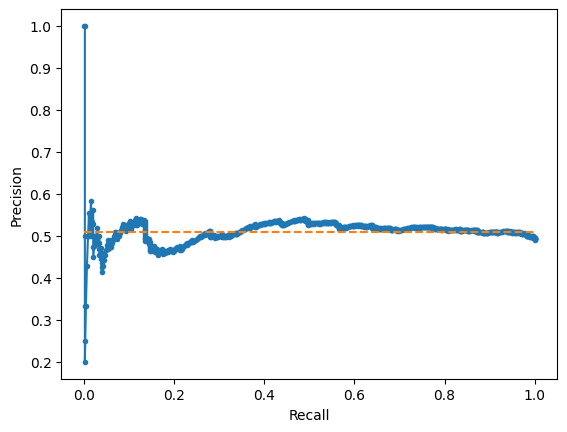

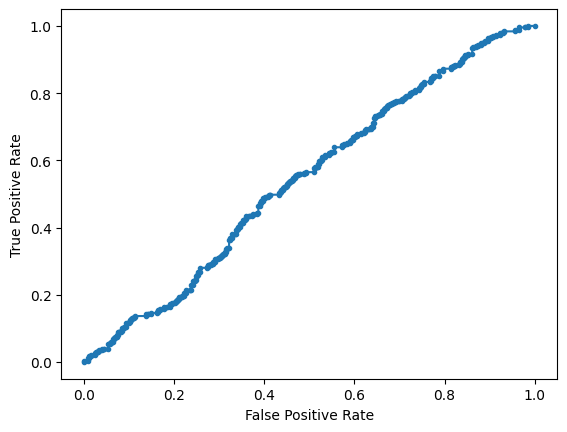

Accuracy: 52.67% Precision: 51.69% Recall: 56.48%
F1: 53.98% MCC: 0.0549
AUPRC: 51.12% AUROC: 54.41%
 accuracy [52.67349260523322]
 precision [51.69491525423729]
 recall [56.481481481481474]
 F1 [53.98230088495575]
 MCC [0.054890010714617105]
 AUPRC [51.121895226949334]
 AUROC [54.40928204490844]
2023-03-27 14:49:22.427151

Training # 2 5
2023-03-27 14:49:22.427208
2023-03-27 14:49:22.427235
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 14:49:22.500955


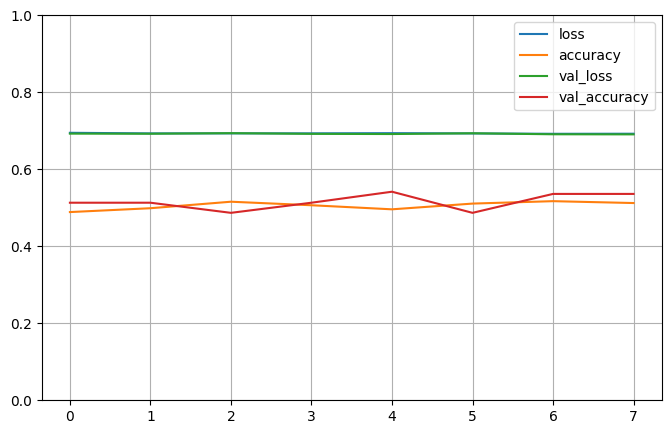


2023-03-27 14:49:26.485622

Testing # 2 5
2023-03-27 14:49:26.485667
2023-03-27 14:49:26.485684
PREDICT
2023-03-27 14:49:26.490365
Test 1:0 449:426 51.31%
Predict 1:0 829:46 94.74%
Test sizes (875, 257) (875,)
Range of scores: 0.49243644 to 0.528142
Score threshold 0.5
Confusion matrix
 [[ 33 393]
 [ 13 436]]
Normalized matrix
 [[0.03771429 0.44914286]
 [0.01485714 0.49828571]]


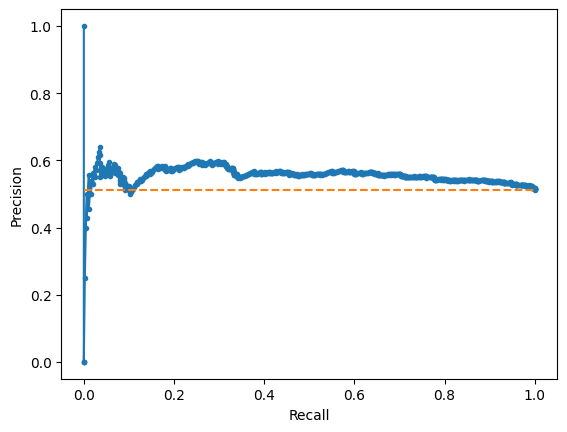

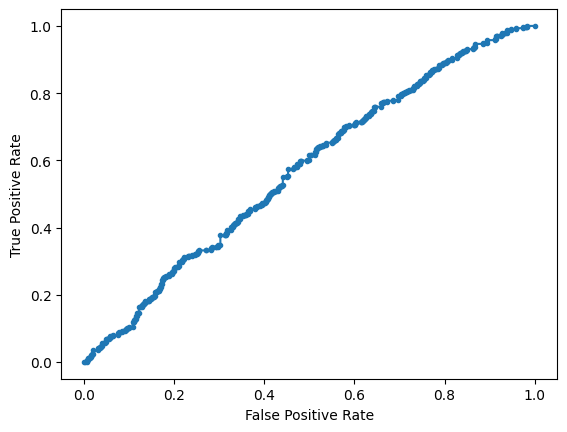

Accuracy: 53.60% Precision: 52.59% Recall: 97.10%
F1: 68.23% MCC: 0.1086
AUPRC: 55.54% AUROC: 57.08%
 accuracy [53.6]
 precision [52.5934861278649]
 recall [97.10467706013362]
 F1 [68.23161189358373]
 MCC [0.10864682103604284]
 AUPRC [55.54268295353542]
 AUROC [57.0843397429865]
2023-03-27 14:49:27.001046


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 51.41% std 3.09
 precision mean 42.17% std 22.35
 recall mean 47.49% std 35.43
 F1 mean 41.98% std 27.30
 MCC mean 0.04% std 0.05
 AUPRC mean 53.68% std 1.39
 AUROC mean 54.05% std 1.46
 accuracy [[46.89655172413793], [53.05429864253394], [53.592461719670204], [55.50561797752809], [52.62557077625571], [46.786922209695604], [47.926267281105986], [51.3953488372093], [52.67349260523322], [53.6]]
 precision [[46.666666666666664], [53.562005277044854], [53.125], [55.67567567567567], [54.285714285714285], [0.0], [0.0], [54.060324825986086], [51.69491525423729], [52.5934861278649]]
 recall [[6.11353711790393], [45.92760180995475], [92.3076923076923], [67.3202614379085], [58.20568927789934], [0.0], [0.0], [51.434878587196465], [56.481481481481474], [97.10467706013362]]
 F1 [[10.81081081081081], [49.451887941534714], [67.43801652892563], [60.94674556213019], [56.177402323125655], [0.0], [0.0], [52.71493212669682], [53.98230088495575], [68.23161189358373]]
 MCC [[-0.03258030250460